In [3]:
import netCDF4 as nc
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import sys
import calendar

import PlotTools.plot_tools as PTs
import pandas as pd

import iris
import iris.plot as iplt
import iris.quickplot as qplt

from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (15.,10)

from iris_jules import jules


In [4]:
def netcdf_read_onto_grid(var,inf,grindex,grimask,fill_value=-999):
    griddata=Jinf.variables[var][:].squeeze()
    griddata=np.ma.masked_array(griddata[...,grindex],mask=grimask,fill_value=fill_value)
    griddata.data[griddata.mask==True]=fill_value
    return griddata

In [21]:
fill_value=-999.

BVOC_DIR='/prj/wetlands_africa/jules/JASMIN/BVOCs/'

OUT_DIR=BVOC_DIR+'ECP_plots/'

JULES_DIR=BVOC_DIR+'/JULES_OUTPUT/'
Jrunids = ['J4.6_EMEP4UK_VG',\
           'J4.6_EMEP4UK_VG_tefld']
Jrun_snames = ['VG_std','VG_tefld']

PP_Jruns=['J4.6_EMEP4UK_VG_JULES','J4.6_EMEP4UK_VG_ECP2']#,'J4.6_EMEP4UK_VG_MEGAN']

EMEP4UK_DIR=BVOC_DIR+'EMEP4UK_output/rv4.3/'
EMEP4UK_tag='EMEP4UK_UK_webrun_emep_4.3_'

profile='monthly'
file_tsteps=12

invars=['isoprene','terpene','gpp','tstar']

FRAC_file=BVOC_DIR+'JULES_ancils/'+\
            'EMEP4UK_LandFrac.nc'
    
LAI_file=BVOC_DIR+'JULES_ancils/'+\
            'EMEP4UK_LAI.nc'

AREA_file=BVOC_DIR+'EMEP4UK_output/rv4.3/'+\
            'EMEP4UK_UK_webrun_emep_4.3_Area_Grid_km2.nc'

GRID_file = '/users/eow/edwcom/EMEP/EMEP4UK/EMEP4UK_JULES_output_index.nc'

country_file='/users/eow/edwcom/EMEP/EMEP4UK/EMEP4UK_CountryFile.nc'


In [22]:
START_YEAR=2001
END_YEAR=2014
Ndays_month=np.array([31,28,31,30,31,30,31,31,30,31,30,31])
Ndays_month_leap=np.array([31,29,31,30,31,30,31,31,30,31,30,31])


In [23]:
PFT_names=['TB-conif','TB-decid','Med-Needle','Med-Broadleaf',\
           'TB-Crop','Med-Crop','Root-crop',\
           'Moorland','Grass','Med-Scrub']

LF_names=PFT_names+['Soil','Lake','Ice','Urban']
nLFs=len(LF_names)

# index for the relevant PFTs:
PFT_index=[0,1,4,6,7,8]

nPFTs=len(PFT_index)

In [24]:
EFiso_EMEP=np.array([1.00,15.00,4.00,0.10,0.10,0.10,0.10,5.00,0.10,8.00])
EFiso_EMEP_ECP=np.array([10.85,82.51,3.13,0.27,0.10,0.10,0.10,5.00,0.10,8.00])
EFiso_EMEP_ECP2=np.array([1.9,41.5,0.9,0.2,0.10,0.10,0.10,5.00,0.10,8.00])
EFiso_JULES=np.array([8.,35.,8.,16.,16.,16.,20.,10.,16.,20.])
EFiso_MEGAN=np.array([7.2,74.7,7.2,74.7,0.016,0.016,0.008,22.4,12.8,32])


EFiso_Dict = { 'std':EFiso_EMEP[PFT_index], \
               'ECP':EFiso_EMEP_ECP[PFT_index], \
               'ECP2':EFiso_EMEP_ECP2[PFT_index], \
               'JULES':EFiso_JULES[PFT_index], \
               'MEGAN':EFiso_MEGAN[PFT_index] }


In [37]:
EFterp_JULES=np.array([2.4,1.33,2.4,1.2,0.8,0.8,1.25,1,0.8,1.25])
EFterp_EMEP=np.array([2.5,4.00,4.20,10.20,0.40,0.40,0.40,1.00,1.00,2.50,])
EFterp_EMEP_ECP=np.array([12.60,0.52,6.76,0.49,0.20,0.20,0.20,0.50,0.50,2.00,])
EFterp_EMEP_ECP2=np.array([7.5,7.0,4.6,28.7,0.20,0.20,0.20,0.50,0.50,2.00,])

EFterp_Dict= { 'std':EFterp_EMEP[PFT_index], \
               'ECP':EFterp_EMEP_ECP[PFT_index], \
               'ECP2':EFterp_EMEP_ECP2[PFT_index], \
               'JULES':EFterp_JULES[PFT_index]}


In [26]:
LAND_FRAC=nc.Dataset(FRAC_file,'r').variables['Land_Frac'][:]
PFT_FRAC=LAND_FRAC[PFT_index,:]

AREA=nc.Dataset(AREA_file,'r').variables['Area_Grid_km2'][0,:]*1e6


In [27]:
# Read in Grid File
GRINF=nc.Dataset(GRID_file,'r')
GRINDEX=GRINF.variables['land_index'][:]
lats_2d=GRINF.variables['lats'][:]
lons_2d=GRINF.variables['lons'][:]
print(PFT_index)
GRIMASK_TSTEPsPFTs= np.array( [ [GRINDEX.mask for iPFT in PFT_names] \
                                              for iTSTEP in range(file_tsteps) ] )
GRIMASK_TSTEPsLFs= np.array( [ [GRINDEX.mask for iLF in LF_names] \
                                              for iTSTEP in range(file_tsteps) ] )
GRIMASK_TSTEPs= np.array( [ GRINDEX.mask for iTSTEP in range(file_tsteps) ] )


[0, 1, 4, 6, 7, 8]


In [28]:

# read Country Mask from file
cntinf=nc.Dataset(country_file,'r')
CountryMask=cntinf.variables['Country'][:]
CountryNote=cntinf.variables['Country'].note
cntinf.close()

Country_names = ['UK','England','Scotland','Wales','Northern Ireland','Ireland']
Country_Indexes= [ np.where((CountryMask>=1)&(CountryMask<=4)), \
                   np.where(CountryMask==1), \
                   np.where(CountryMask==2), \
                   np.where(CountryMask==3), \
                   np.where(CountryMask==4), \
                   np.where(CountryMask==5), \
                 ]
Ncnts=len(Country_names)
print(CountryNote)

Water=0, England=1, Scotland=2, Wales=3, Northern Ireland=4, Ireland=5, France=6, Beglium=7, Netherlands=8, Denmark=9, Norway=10


In [29]:
#for iLF in range(nLFs):
#    FILEPLOTname='/users/eow/edwcom/EMEP/EMEP4UK/plots/ancils/USED_LF/'+str(iLF)+'-'+LF_names[iLF]+'.png'
#    PLOTDATA=np.ma.masked_less(LAND_FRAC[iLF,:],0.01)
#    PTs.plot_map(PLOTDATA,lons_2d,lats_2d,\
#                 FILE_PLOT=FILEPLOTname,iDISPLAY='N',\
#                 CMAP='OrRd',NLEVELS=250,TICK_FORMAT='%0.1f',NTICKS=11,\
#                 LATDEL=2,LONDEL=2, LON_RANGE=[-13,10.8],LAT_RANGE=[51.5,56.8], \
#                 DATA_RANGE=[0,1], \
#                 FONTSIZES=[15,15,18,18], \
#                 PLOT_TITLE=LF_names[iLF], \
#                 CBAR_ORIENTATION='vertical', \
#                 WIDTH=8,HEIGHT=9,RESOLUTION='i',PROJECTION='stere' \
#                  )

In [30]:
print(PFT_FRAC.shape)
print(AREA.shape)
print(GRIMASK_TSTEPsPFTs.shape)
print(lats_2d.shape)
print(lons_2d.shape)

(6, 270, 220)
(270, 220)
(12, 10, 270, 220)
(270, 220)
(270, 220)


In [31]:

ISO_Dict={}
TERP_Dict={}
TSTAR_Dict={}
GPP_Dict={}
PAR_Dict={}
TIME_Dict={}
ISO_tot_Dict={}
TERP_tot_Dict={}

year=START_YEAR
Jrunid=Jrunids[0]
for Jrunid in Jrunids:
    for year in range(START_YEAR,END_YEAR+1):
        J_fname=JULES_DIR+Jrunid+'/'+Jrunid+'.'+profile+'.'+str(year)+'.nc'
    
        Jinf=nc.Dataset(J_fname,'r')
        
        Jtime=nc.num2date(Jinf.variables['time'][:],\
                          units=Jinf.variables['time'].units)

        # Read in ISO, Terp, tstar and gpp data onto 2D lat lon Grids
        # Isoprene
        temp_ISOdata=netcdf_read_onto_grid('isoprene',Jinf,\
                                           GRINDEX,GRIMASK_TSTEPsPFTs,\
                                           fill_value=fill_value)
        temp_TERPdata=netcdf_read_onto_grid('terpene',Jinf,\
                                           GRINDEX,GRIMASK_TSTEPsPFTs,\
                                           fill_value=fill_value)
        temp_TSTARdata=netcdf_read_onto_grid('tstar',Jinf,\
                                           GRINDEX,GRIMASK_TSTEPsLFs,\
                                           fill_value=fill_value)
        temp_GPPdata=netcdf_read_onto_grid('gpp',Jinf,\
                                           GRINDEX,GRIMASK_TSTEPsPFTs,\
                                           fill_value=fill_value)
        
        temp_SWdata=netcdf_read_onto_grid('sw_down',Jinf,\
                                           GRINDEX,GRIMASK_TSTEPs,\
                                           fill_value=fill_value)
        
    
        Jinf.close()
    
        # convert data units (Iso and Terp to g day^-1, GPP to kg day) 
        # and append along time axis
        # and extract the relevant PFTs
        if year==START_YEAR:
        #                           cover * Area in m^2 * second in day * g in kg
            ISO_Data=temp_ISOdata[:,PFT_index,:]*PFT_FRAC*AREA*86400*1e3
            TERP_Data=temp_TERPdata[:,PFT_index,:]*PFT_FRAC*AREA*86400*1e3
            TSTAR_Data=temp_TSTARdata[:,PFT_index,:].copy()
            GPP_Data=temp_GPPdata[:,PFT_index,:]*PFT_FRAC*AREA*86400
            PAR_Data=temp_SWdata*0.5
            TIME_Data=Jtime.copy()
        else:
            ISO_Data=np.append(ISO_Data,temp_ISOdata[:,PFT_index,:]*PFT_FRAC*AREA*86400*1e3,axis=0)
            TERP_Data=np.append(TERP_Data,temp_TERPdata[:,PFT_index,:]*PFT_FRAC*AREA*86400*1e3,axis=0)
            TSTAR_Data=np.append(TSTAR_Data,temp_TSTARdata[:,PFT_index,:],axis=0)
            GPP_Data=np.append(GPP_Data,temp_GPPdata[:,PFT_index,:]*PFT_FRAC*AREA*86400,axis=0)
            PAR_Data=np.append(PAR_Data,temp_SWdata*0.5,axis=0)
            TIME_Data=np.append(TIME_Data, Jtime)

    #print(ISO_Data.shape)
    #print(TERP_Data.shape)
    #print(TSTAR_Data.shape)
    #print(GPP_Data.shape)
    #print(PAR_Data.shape)
    ISO_Dict[Jrunid]=ISO_Data.copy()
    TERP_Dict[Jrunid]=TERP_Data.copy()
    ISO_tot_Dict[Jrunid]=np.sum(ISO_Data,axis=1)
    TERP_tot_Dict[Jrunid]=np.sum(TERP_Data,axis=1)
    TSTAR_Dict[Jrunid]=TSTAR_Data.copy()
    GPP_Dict[Jrunid]=GPP_Data.copy()
    PAR_Dict[Jrunid]=PAR_Data.copy()
    TIME_Dict[Jrunid]=TIME_Data

In [38]:
std_run=Jrunids[0]
print(std_run)
for PPrun in PP_Jruns:
    print(PPrun)
    ISO_Dict[PPrun] = (ISO_Dict[std_run].transpose(0,2,3,1)/EFiso_Dict['std'])\
                        *  EFiso_Dict[PPrun[16:]]
    ISO_Dict[PPrun]=ISO_Dict[PPrun].transpose(0,3,1,2)
    ISO_tot_Dict[PPrun]=np.sum(ISO_Dict[PPrun],axis=1)
    
    TERP_Dict[PPrun] = (TERP_Dict[std_run].transpose(0,2,3,1)/EFterp_Dict['std'])\
                        *  EFterp_Dict[PPrun[16:]]
    TERP_Dict[PPrun]=TERP_Dict[PPrun].transpose(0,3,1,2)
    TERP_tot_Dict[PPrun]=np.sum(TERP_Dict[PPrun],axis=1)
    
    TIME_Dict[PPrun]=TIME_Dict[std_run]
    

J4.6_EMEP4UK_VG
J4.6_EMEP4UK_VG_JULES
J4.6_EMEP4UK_VG_ECP2


In [33]:
# Read in and Append the EMEP4UK data
year=START_YEAR
for year in range(START_YEAR,END_YEAR+1):
    if calendar.isleap(year):
        Ndays=Ndays_month
    else:
        Ndays=Ndays_month_leap
        
    EMEP4UK_file=EMEP4UK_DIR+EMEP4UK_tag+str(year)+'_'+profile+'_BVOCS.nc'
    #print(EMEP4UK_file)
    
    Einf=nc.Dataset(EMEP4UK_file,'r')
    temp_EMtime_obj=nc.num2date(Einf.variables['time'][:],\
                                units=Einf.variables['time'].units)
    
    temp_ISOdata=Einf.variables['Emis_mgm2_BioNatC5H8'][:]
    temp_TERPdata=Einf.variables['Emis_mgm2_BioNatAPINENE'][:]
    temp_T2Mdata=Einf.variables['T2m'][:]
    temp_RH2Mdata=Einf.variables['rh2m'][:]
    Einf.close()
    
    # Change to emission rate per day (g m^-2 day^-1)
    temp_ISOdata=np.array( [temp_ISOdata[imnth]/Ndays[imnth] for imnth in range(12)] )*1e-3
    temp_TERPdata=np.array( [temp_TERPdata[imnth]/Ndays[imnth] for imnth in range(12)] )*1e-3
    
    # Append to data array, and multiply through by Area
    if year==START_YEAR:
        ISO_Data=temp_ISOdata*AREA
        TERP_Data=temp_TERPdata*AREA
        T2M_Data=temp_T2Mdata
        RH2M_Data=temp_RH2Mdata
        EMtime_obj=temp_EMtime_obj
    else:
        ISO_Data=np.append(ISO_Data,temp_ISOdata*AREA,axis=0)
        TERP_Data=np.append(TERP_Data,temp_TERPdata*AREA,axis=0)
        T2M_Data=np.append(T2M_Data,temp_T2Mdata,axis=0)
        RH2M_Data=np.append(RH2M_Data,temp_RH2Mdata,axis=0)
        EMtime_obj=np.append(EMtime_obj,temp_EMtime_obj)
    

ISO_tot_Dict['EMEP4UK']=ISO_Data
TERP_tot_Dict['EMEP4UK']=TERP_Data
TIME_Dict['EMEP4UK']=EMtime_obj
#print(temp_ISOdata.shape)



In [34]:
TIME_Dict['EMEP4UK'].shape
index=Country_Indexes[0]
len(index)
ISO_tot_Dict['EMEP4UK'].shape

(168, 270, 220)

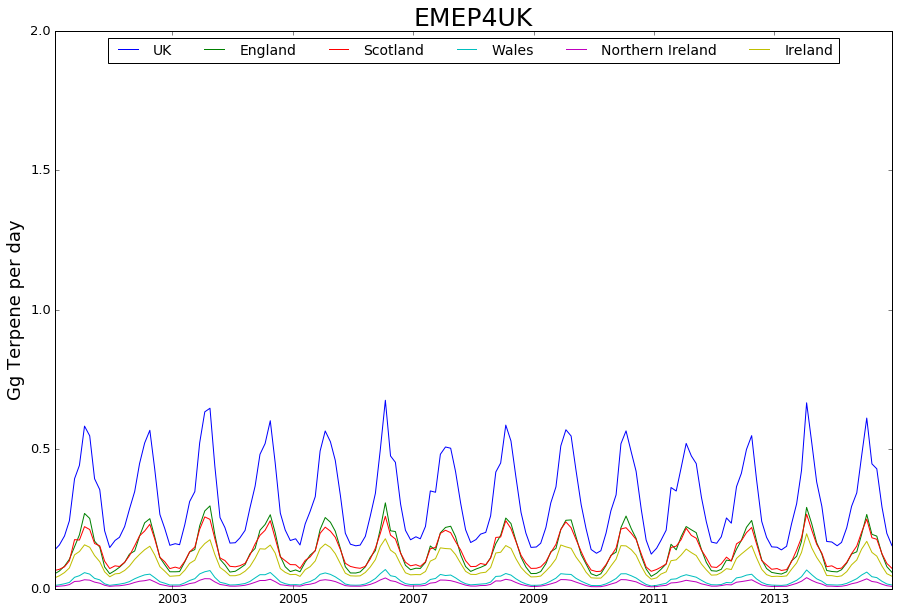

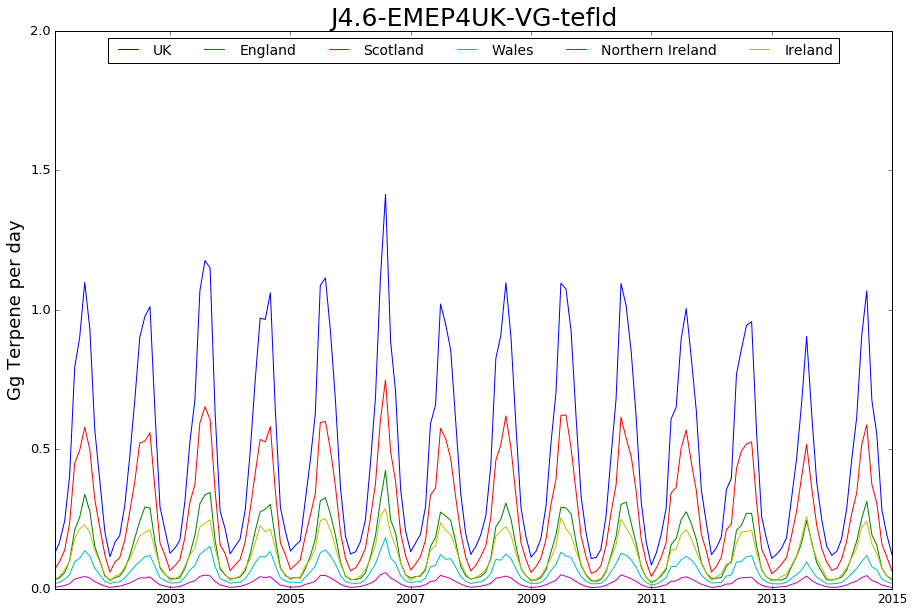

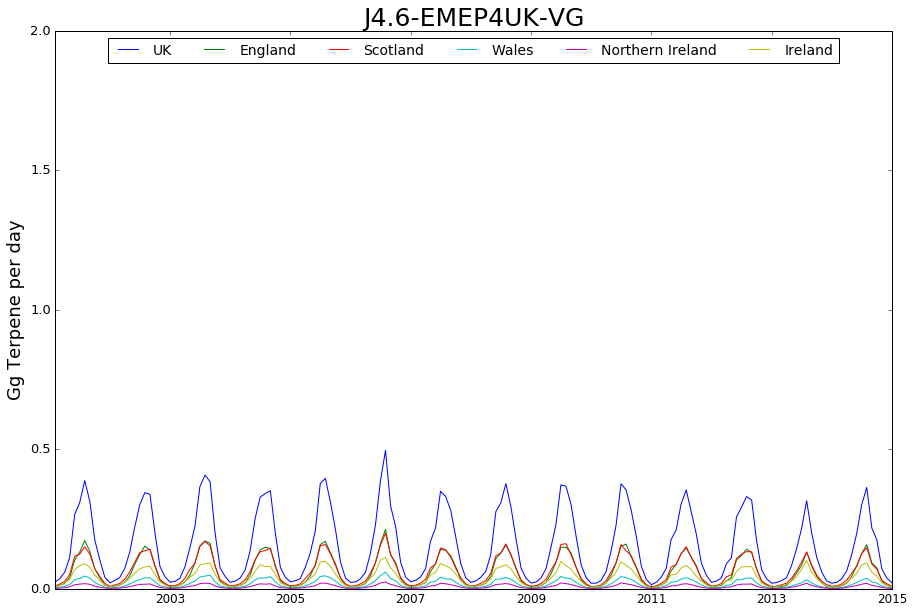

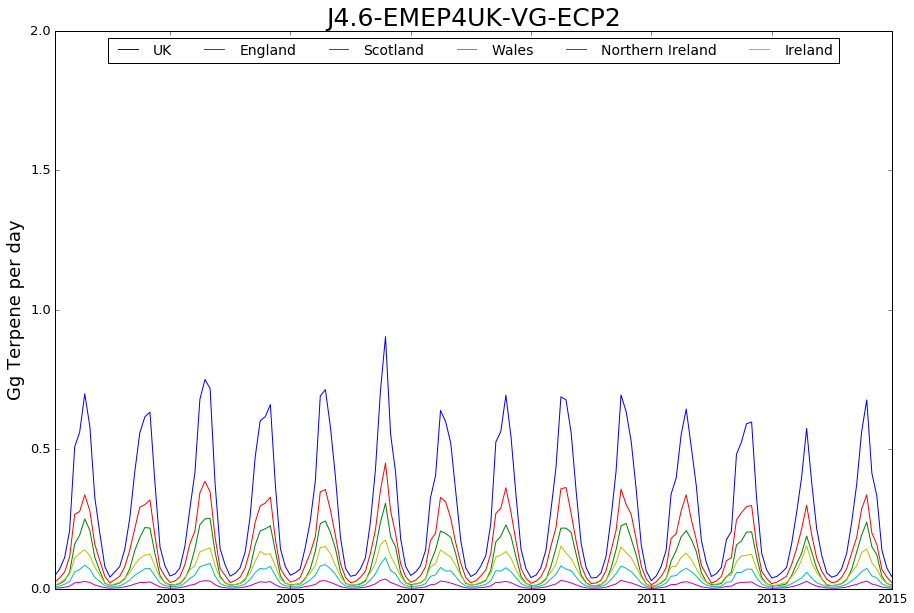

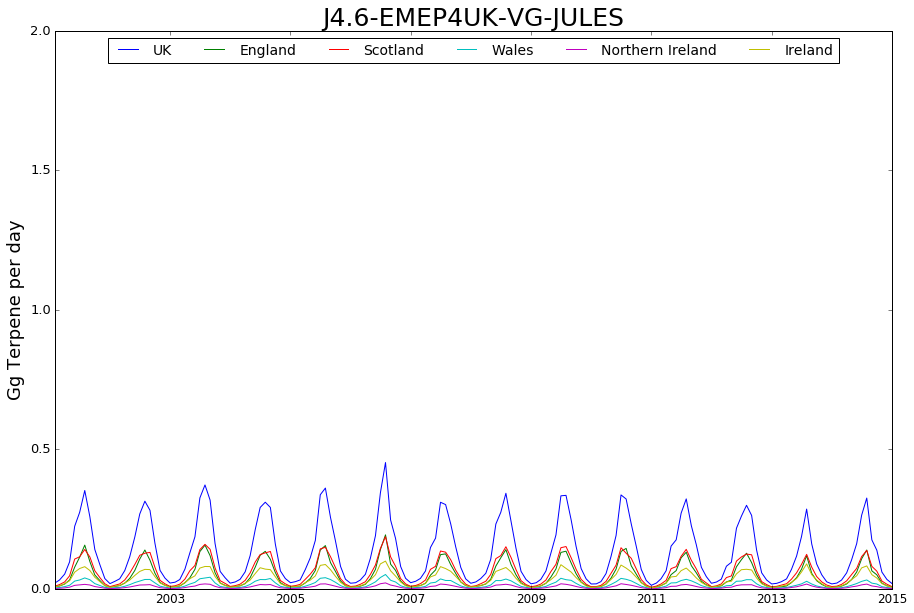

In [39]:
# Plot Full time-series for UK and countries
for run in TERP_tot_Dict:
    for icnt in range(Ncnts):
        index=Country_Indexes[icnt]
        TSdata=np.sum(TERP_tot_Dict[run][:,index[0],index[1]],axis=1)*1e-9
        plt.plot(TIME_Dict[run],TSdata,label=Country_names[icnt])
        plt.title(run.replace('_','-'),fontsize=25)
        plt.ylabel('Gg Terpene per day',fontsize=18)
        plt.yticks(fontsize=13)
        plt.ylim([0,2])
        plt.xticks(fontsize=12)
    plt.legend(loc=9,ncol=Ncnts,fontsize=14)
    plt.show()

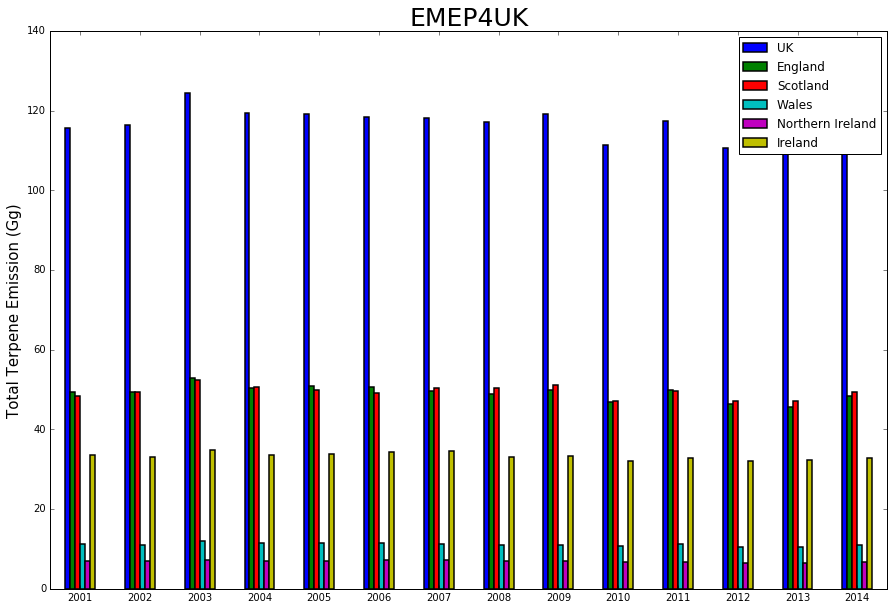

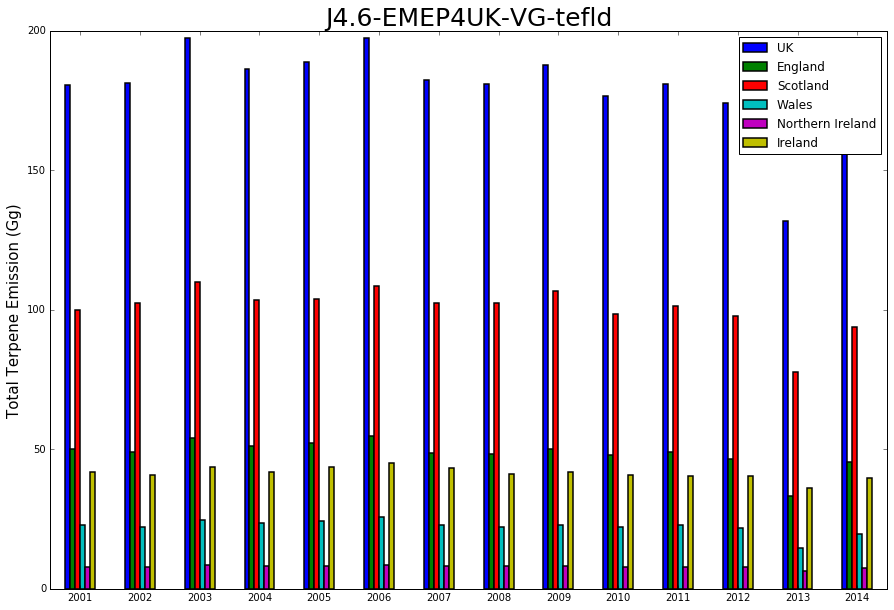

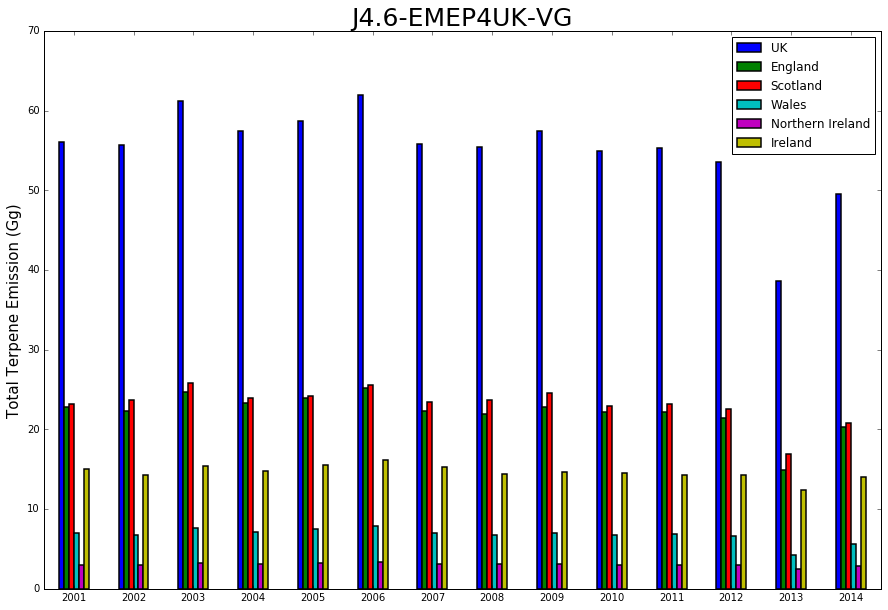

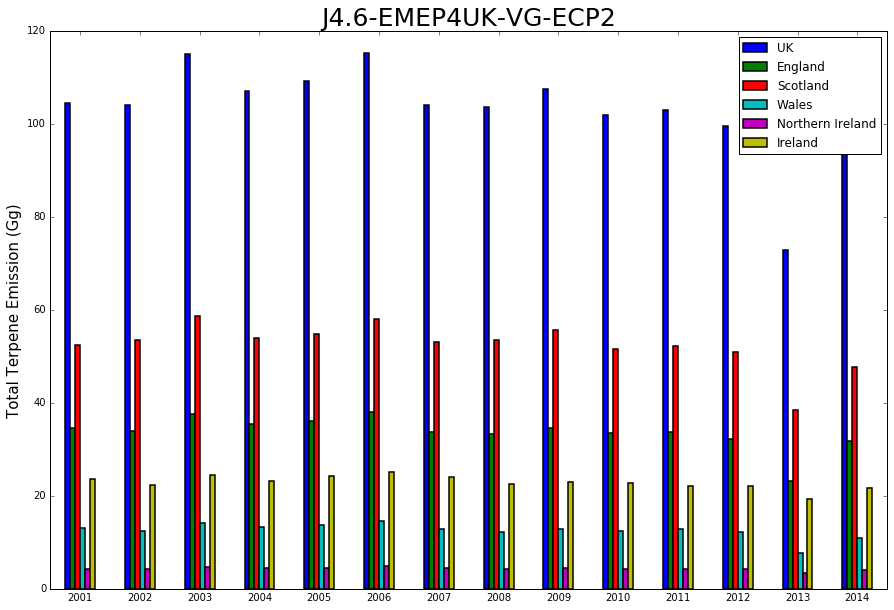

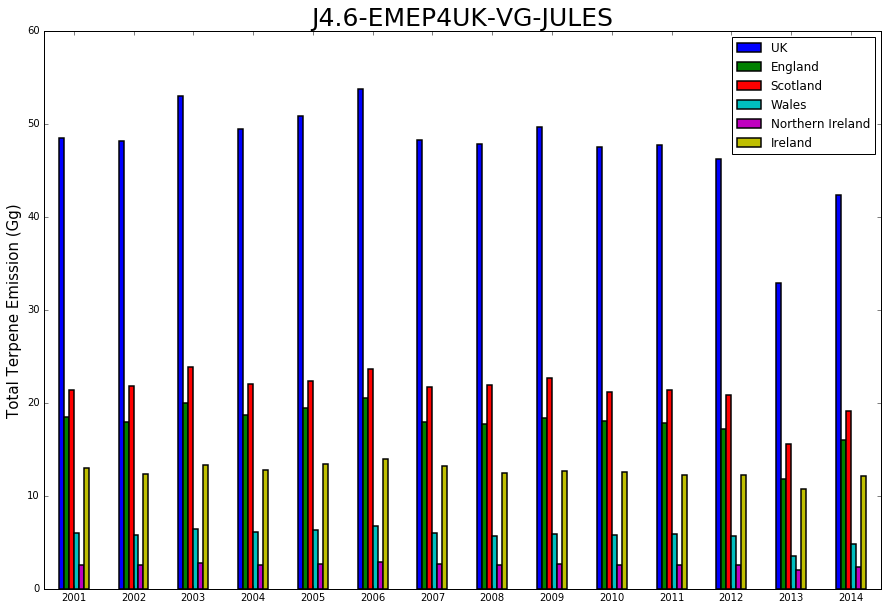

In [40]:
# Plot Bar chart time-series of annual emissions for UK and countries
for run in TERP_tot_Dict:
    TSdict={}
    Tindex=[ Tstep.year for Tstep in TIME_Dict[run][2::12]]
    for icnt in range(Ncnts):
        index=Country_Indexes[icnt]
        TSdata= np.sum(TERP_tot_Dict[run][:,index[0],index[1]],axis=1)*1e-9 
        TSdict[Country_names[icnt]]=np.mean(TSdata.reshape([-1,12]),axis=1)*365
        
    DF=pd.DataFrame(TSdict,index=Tindex) #TIME_Dict[run][::12])
    DF=DF[Country_names]
    DF.plot(kind='bar',lw=1.5)
    plt.ylabel('Total Terpene Emission (Gg)',fontsize=15)
    plt.xticks(rotation=0) 
    plt.title(run.replace('_','-'),fontsize=25)
    
    

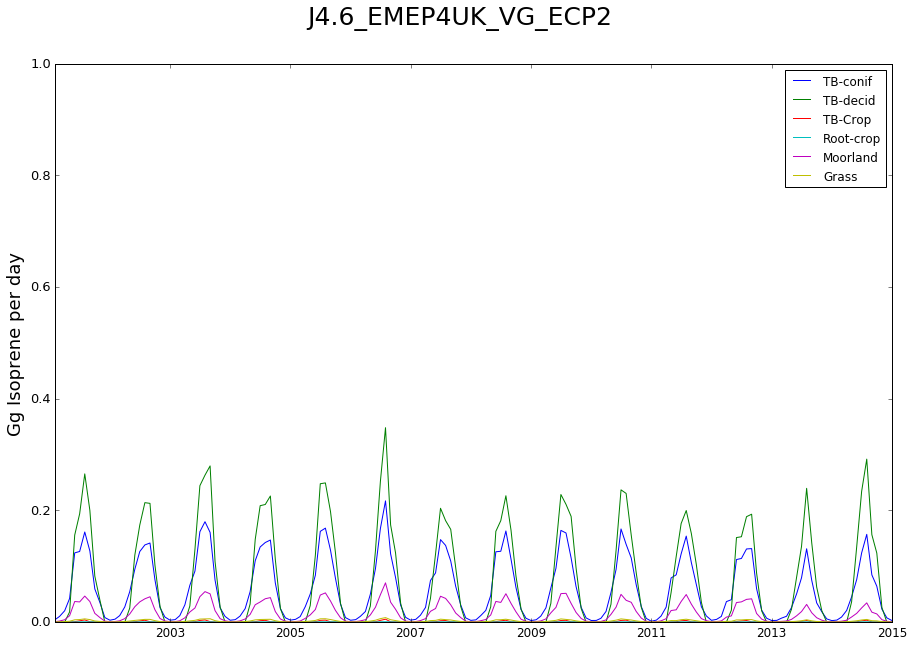

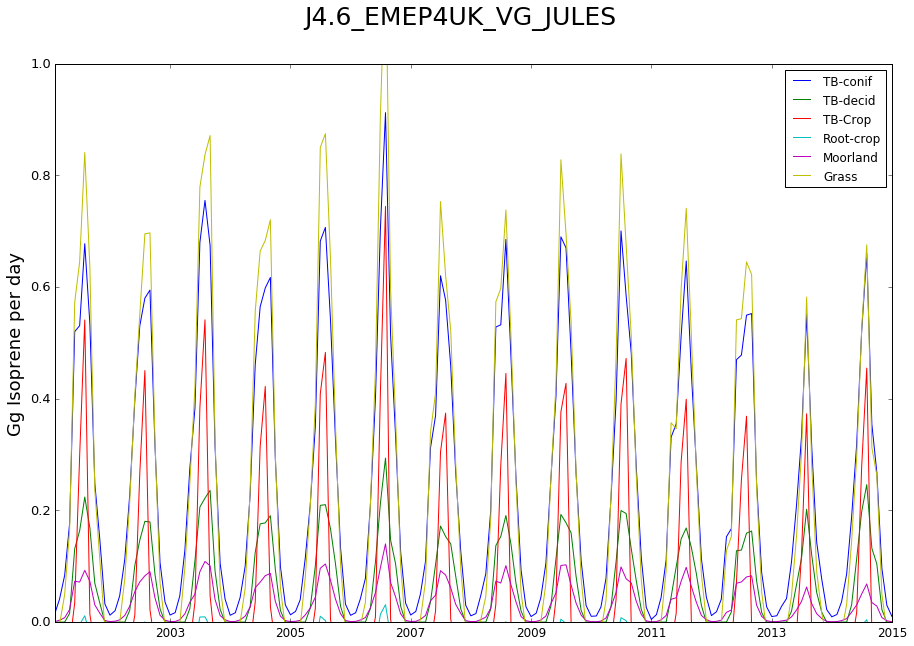

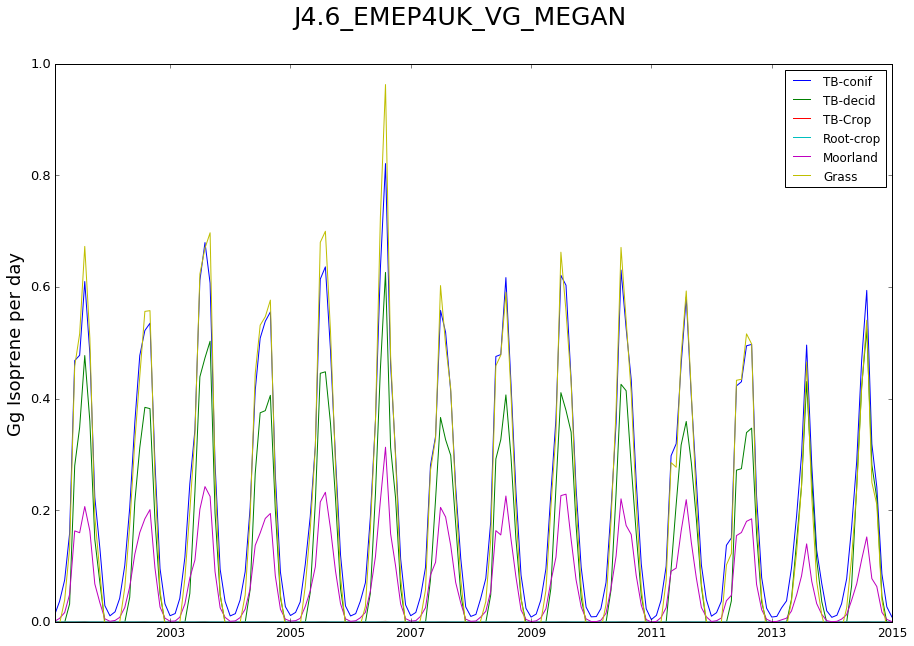

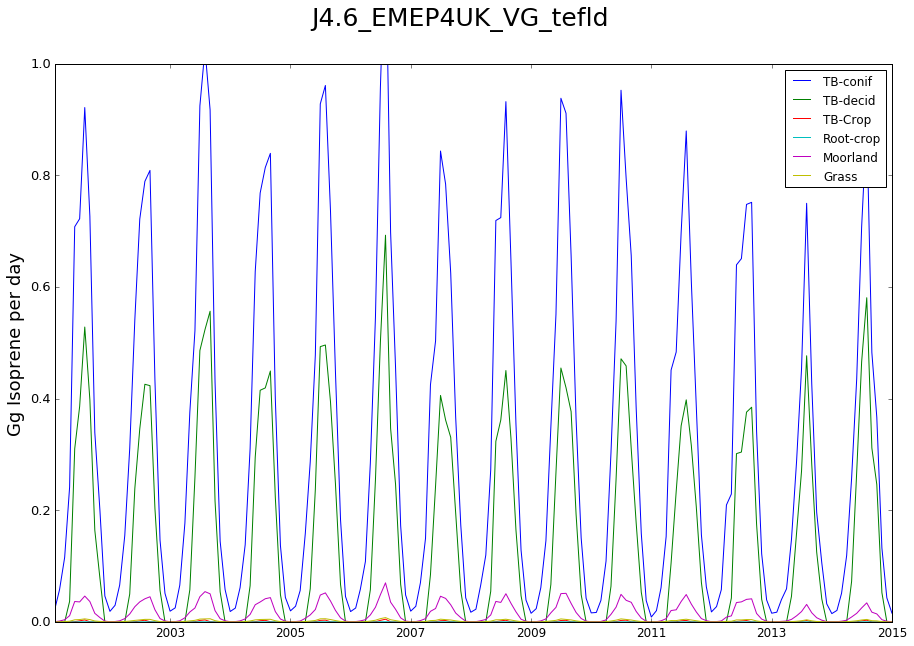

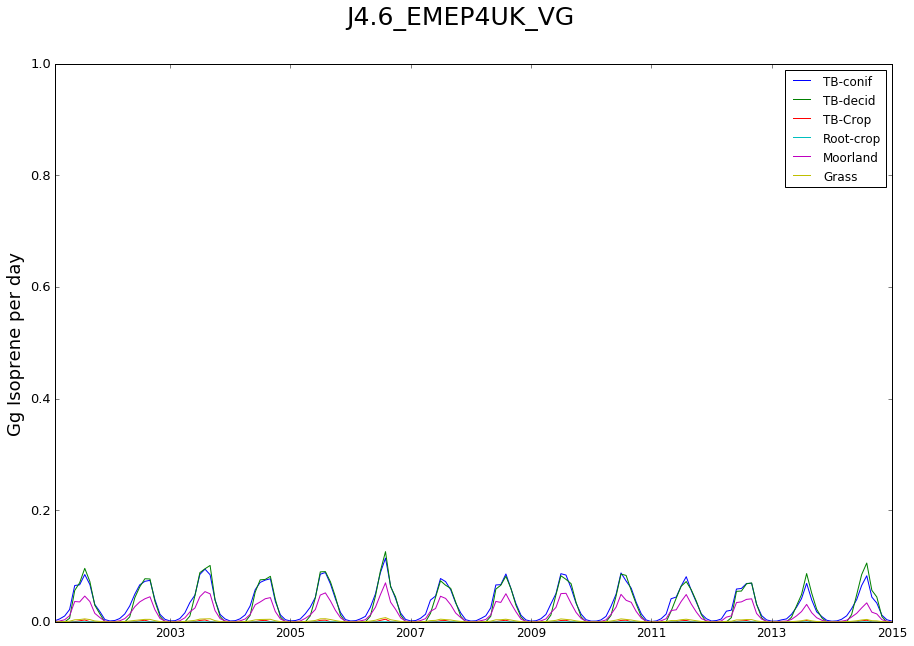

In [67]:
# Plot Full time-series for UK and countries
for run in ISO_Dict:
    
    for iPFT in range(nPFTs):
        PFT_name=PFT_names[PFT_index[iPFT]]
        # Look at UK only
        index=Country_Indexes[0]
        TSdata=np.sum(ISO_Dict[run][:,iPFT,index[0],index[1]],axis=1)*1e-9
        plt.plot(TIME_Dict[run],TSdata,label=PFT_name)
        plt.suptitle(run,fontsize=25)
        plt.ylabel('Gg Isoprene per day',fontsize=18)
        plt.yticks(fontsize=13)
        plt.ylim([0,1.])
        plt.xticks(fontsize=12)
        plt.legend(loc=0)
    plt.show()

In [ ]:
import os
_proc_status = '/proc/%d/status' % os.getpid()
t = open(_proc_status)
v = t.read()
t.close()
print(v)